## Load

In [37]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

np.random.seed=42

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/home/rco/github/p_metaheuristic/data/log


In [38]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

In [39]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [40]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}

uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [41]:
uef[uef.port==1].describe()

,mean_return,var_return,port
count,2000.000000,2000.000000,2000.0
mean,0.006825,0.001579,1.0
std,0.002334,0.001116,0.0
min,0.002784,0.000642,1.0
25%,0.004804,0.000716,1.0
50%,0.006825,0.001058,1.0
75%,0.008845,0.002150,1.0
max,0.010865,0.004776,1.0


In [42]:
df_stats[df_stats.port==1].describe()

,port,i,r_mean,r_std
count,31.0,31.000000,31.000000,31.000000
mean,1.0,16.000000,0.003504,0.045723
std,0.0,9.092121,0.002186,0.007296
min,1.0,1.000000,0.000141,0.035848
25%,1.0,8.500000,0.002043,0.040043
50%,1.0,16.000000,0.003286,0.045450
75%,1.0,23.500000,0.004725,0.050112
max,1.0,31.000000,0.010865,0.069105


In [43]:
df_cov_mx[df_cov_mx.port==1].describe()

,port,i,j,cov
count,496.0,496.000000,496.000000,496.000000
mean,1.0,11.000000,21.000000,0.556209
std,0.0,7.423686,7.423686,0.178871
min,1.0,1.000000,1.000000,0.139539
25%,1.0,5.000000,16.000000,0.452670
50%,1.0,10.000000,22.000000,0.554651
75%,1.0,16.000000,27.000000,0.654551
max,1.0,31.000000,31.000000,1.000000


In [44]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df['log_iter'] = df.index.values
        df.loc[df[-1:].index, 'last_iter'] = 1
        return df
    except:
        print(filename)


futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


In [45]:
all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(61510, 19)
(610, 19)


In [10]:
best_data.tag.value_counts()

tuning_iter    250
Name: tag, dtype: int64

## Ajuste dos Parâmetros

### Iterations

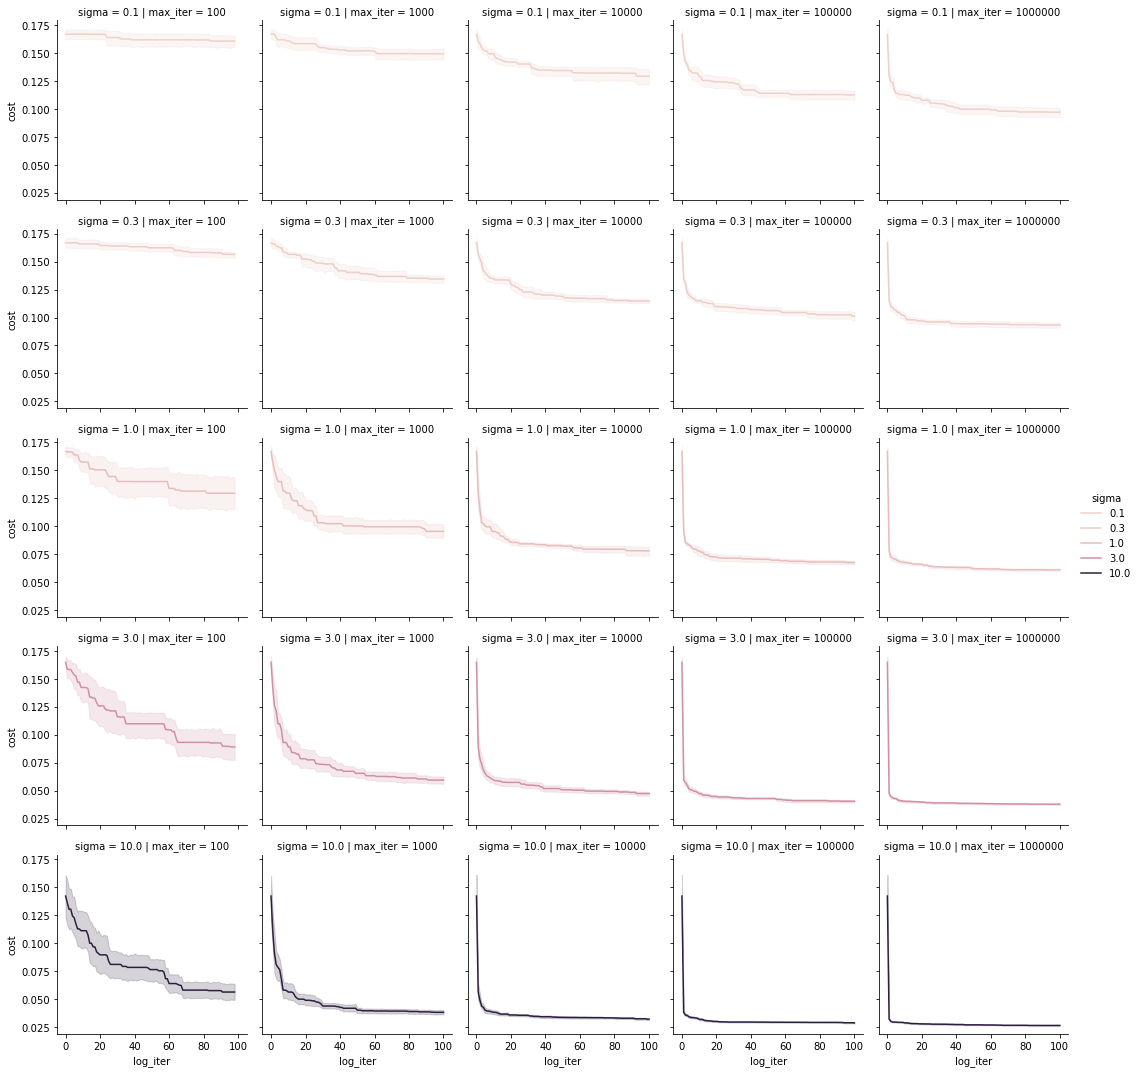

In [11]:
tag = 'tuning_iter'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', row='sigma', col='max_iter', hue='sigma', kind='line', height=3)

In [14]:
best_data_ = best_data[best_data.tag==tag]
best_data_ \
        .groupby(['max_iter', 'sigma'], as_index=False)['cost'] \
        .mean() \
        .sort_values('cost') \
        .rename({'max_iter':'MNI', 'cost':'Cost', 'sigma':'Sigma'}, axis=1) \
        .head(10)

,MNI,Sigma,Cost
24,1000000,10.0,0.026535
19,100000,10.0,0.028833
14,10000,10.0,0.032164
23,1000000,3.0,0.037837
9,1000,10.0,0.038266
18,100000,3.0,0.040458
13,10000,3.0,0.047366
4,100,10.0,0.056407
8,1000,3.0,0.059410
22,1000000,1.0,0.060905


### Sigma

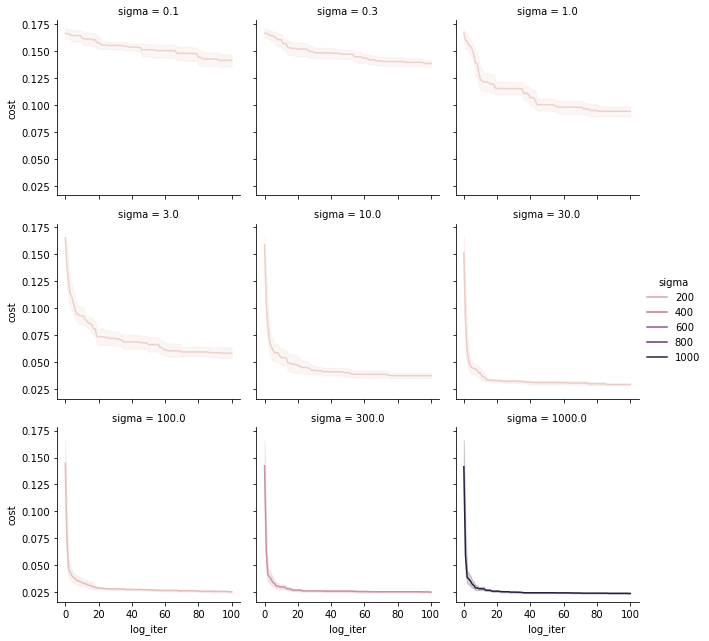

In [10]:
tag = 'tuning_sigma'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='sigma', col_wrap=3, hue='sigma', kind='line', height=3)

In [11]:
best_data_ = best_data[best_data.tag==tag]
best_data_ \
        .groupby(['sigma'], as_index=False)['cost'] \
        .mean() \
        .sort_values('cost') \
        .rename({'max_iter':'MNI', 'cost':'Cost', 'sigma':'Sigma'}, axis=1) \
        .head(20)

,Sigma,Cost
8,1000.0,0.023970
7,300.0,0.025220
6,100.0,0.025526
5,30.0,0.029278
4,10.0,0.037398
3,3.0,0.058204
2,1.0,0.094132
1,0.3,0.138464
0,0.1,0.141386


### Mem Size

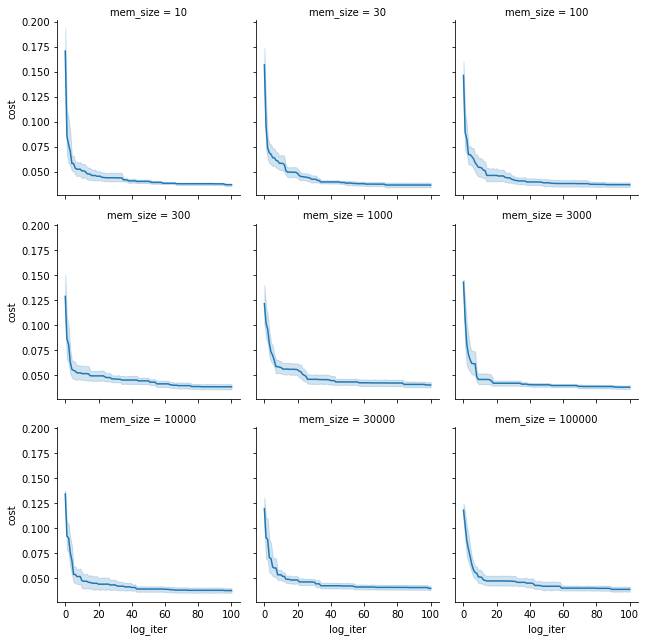

In [22]:
tag = 'tuning_mem_size'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='mem_size', col_wrap=3,
            kind='line', height=3)

In [25]:
best_data_ = best_data[best_data.tag==tag]
best_data_ \
        .groupby(['mem_size'], as_index=False)['cost'] \
        .mean() \
        .sort_values('cost') \
        .rename({'cost':'Cost', 'mem_size':'HMS'}, axis=1) \
        .head(20)

,HMS,Cost
1,30,0.036728
0,10,0.037047
2,100,0.037077
6,10000,0.037650
5,3000,0.037821
3,300,0.038194
8,100000,0.038862
7,30000,0.039833
4,1000,0.040028


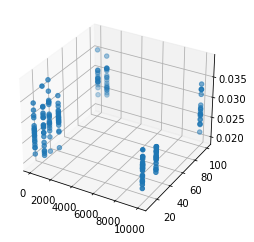

In [235]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(best_data_.pop_size,
           best_data_.mem_size,
           best_data_.cost)

### Mem Consider

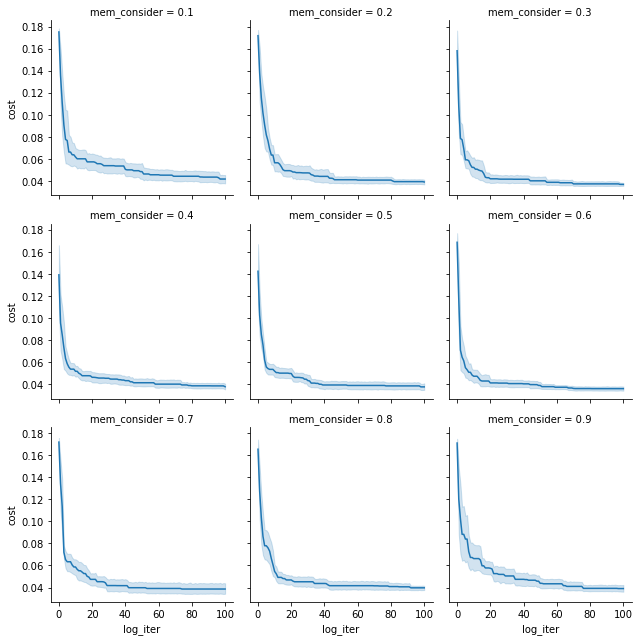

In [35]:
tag = 'tuning_mem_consider'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='mem_consider', col_wrap=3, kind='line', height=3)

In [36]:
best_data_ = best_data[best_data.tag==tag]
best_data_ \
        .groupby(['mem_consider'], as_index=False)['cost'] \
        .mean() \
        .sort_values('cost') \
        .rename({'cost':'Cost', 'mem_consider':'HMCR'}, axis=1) \
        .head(20)

,HMCR,Cost
5,0.6,0.036039
2,0.3,0.036967
4,0.5,0.037651
3,0.4,0.037786
6,0.7,0.038632
8,0.9,0.039049
1,0.2,0.039149
7,0.8,0.039716
0,0.1,0.041827


### Par

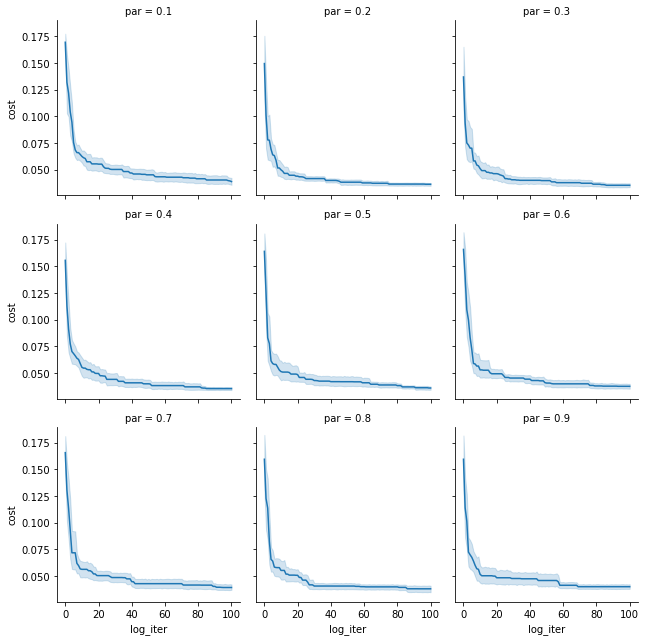

In [47]:
tag = 'tuning_par'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='par', col_wrap=3, kind='line', height=3)

In [50]:
best_data_ = best_data[best_data.tag==tag]
best_data_ \
        .groupby(['par'], as_index=False)['cost'] \
        .mean() \
        .sort_values('cost') \
        .rename({'cost':'Cost', 'par':'PAR'}, axis=1) \
        .head(20)

,PAR,Cost
3,0.4,0.035232
2,0.3,0.035311
4,0.5,0.035805
1,0.2,0.036289
5,0.6,0.037394
7,0.8,0.038086
0,0.1,0.038819
6,0.7,0.039315
8,0.9,0.040055


### Sigma

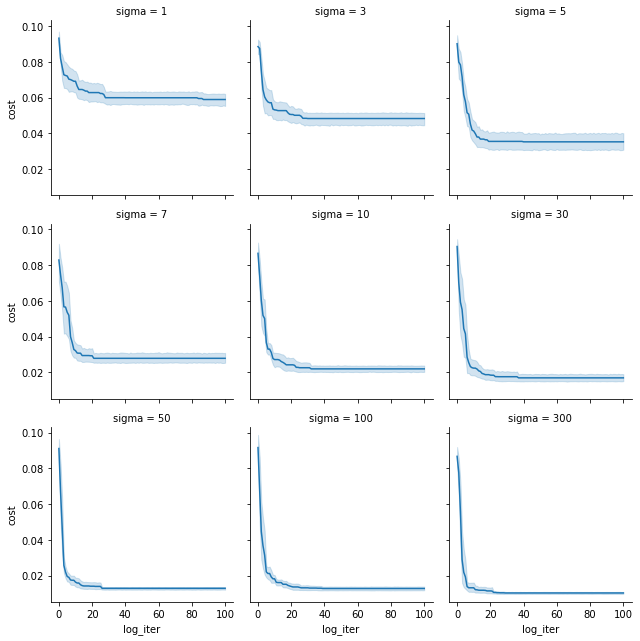

In [180]:
tag = 'tuning_sigma'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='sigma', col_wrap=3, kind='line', height=3)

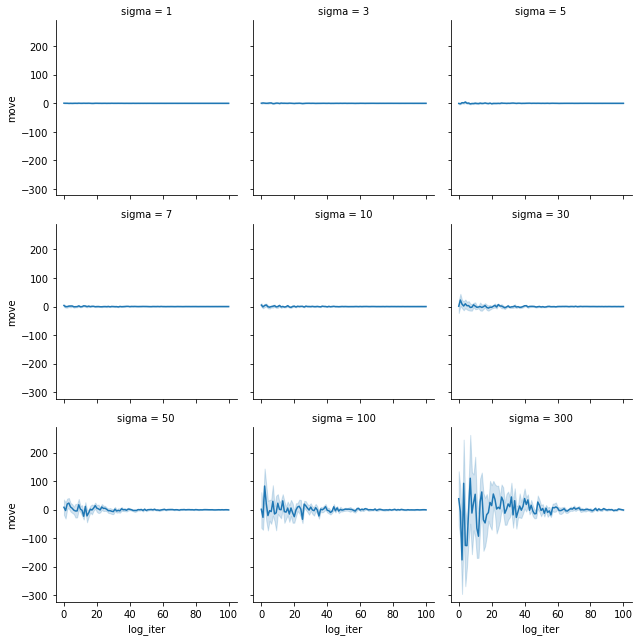

In [181]:
sns.relplot(data=data, x='log_iter', y='move', col='sigma', col_wrap=3, kind='line', height=3)

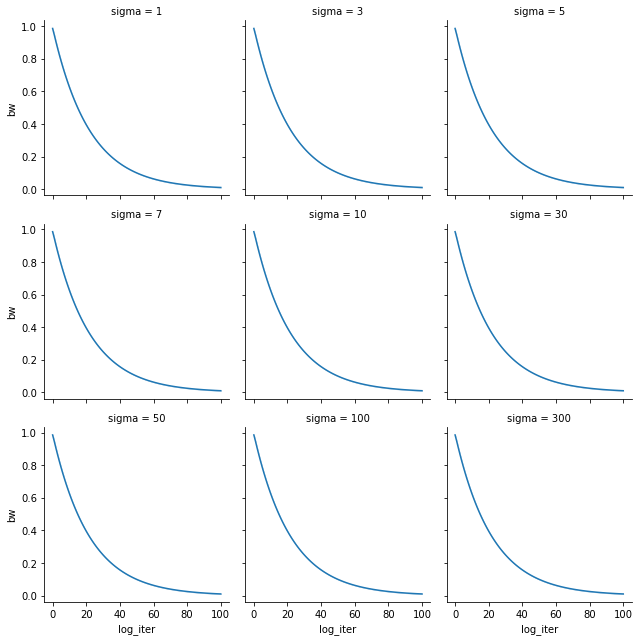

In [182]:
sns.relplot(data=data, x='log_iter', y='bw', col='sigma', col_wrap=3, kind='line', height=3)

In [183]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['sigma'], as_index=False)['cost'].mean().sort_values('cost').head(10)

,sigma,cost
8,300,0.010299
7,100,0.012799
6,50,0.012898
5,30,0.016953
4,10,0.021980
3,7,0.027887
2,5,0.035299
1,3,0.048348
0,1,0.058988


### Iterations

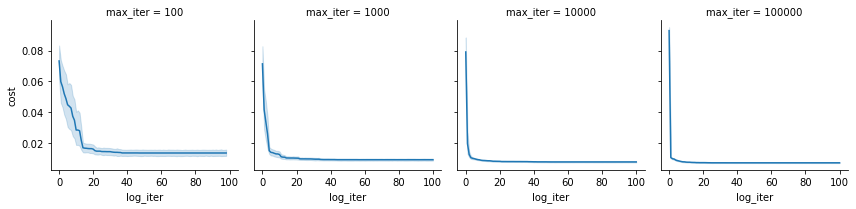

In [297]:
tag = 'tuning_iter'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='max_iter', kind='line', height=3)

In [298]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['max_iter'], as_index=False)['cost'].mean().sort_values('cost')

,max_iter,cost
3,100000,0.007045
2,10000,0.007622
1,1000,0.009054
0,100,0.013431


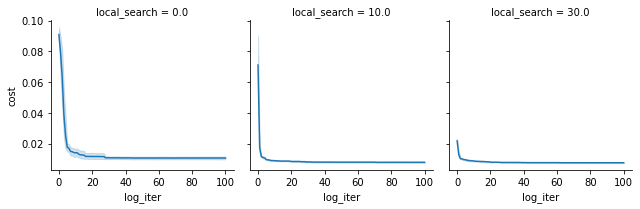

In [283]:
tag = 'tuning_local_search'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='local_search', kind='line', height=3)

In [287]:
best_data_ = best_data[best_data.tag==tag]
best_data_.groupby(['local_search'], as_index=False)['cost'].mean().sort_values('cost')

,local_search,cost
2,30.0,0.007505
1,10.0,0.007789
0,0.0,0.010567
